# Модель оценки заголовка

Введенные или сгенерированные заголовки нужно как-то оценивать. Так как главной целью обычно является увеличение количества просмотров, то в качестве критерия можно использовать число просмотров у ранее опубликованных статей.

Таким образом, перед нами стоит задача регрессии: на входе заголовок, на выходе число (балл от 0 до 10 с точностью 0.1).

В качестве библиотеки, реализующей модель русского языка, мы используем spaCy (в первую очередь из соображений скорости).

## 1. Подготовка датасета

В нашем распоряжении множество данных, полученных в результате парсинга. Объединим их в один большой датасет для построения модели оценки заголовков. Для его построения нам нужны те датасеты (сайты), для которых имеется информация о количестве просмотров статьи.

In [34]:
# standard libraries
import pickle

# data processing libraries
import numpy as np
import pandas as pd

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# data processing progress bar
from tqdm.auto import tqdm
tqdm.pandas()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# обработка естественного языка
import spacy
spacy.prefer_gpu()
nlp = spacy.load("ru_core_news_lg")

In [36]:
# библиотеки для машинного и глубокого обучения
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

2.4.1


In [5]:
# пути к датасетам
DATASETS_PATH = "/home/leo/DATASETS"
TOKENIZED_TITLES_PATH = f"{DATASETS_PATH}/tokenized_titles.pickle"

In [6]:
# словарь с источником данных и их характеристиками
with open('../sources.pickle', 'rb') as f:
    sources = pickle.load(f)

In [7]:
# Токенизация большого числа заголовков — затратная по времени операция.
# Поэтому предварительно токенизированные заголовки хранятся в виде
# сжатого датафрайма
tokenized_titles = pd.read_pickle(TOKENIZED_TITLES_PATH, compression='gzip')

In [8]:
# tokenized_titles.to_pickle(path=TOKENIZED_TITLES_PATH, compression='gzip')

In [9]:
# соединяем датасеты в один общий датасет с именем df
dfs = dict()

for source in sources:
    dfs[source] = pd.read_csv(f"{DATASETS_PATH}/{source}.csv",
                              index_col=0,
                              parse_dates=['post_time', 'parse_time'])
    dfs[source]['source'] = source
    
df = pd.concat(dfs[key] for key in dfs)

# удаляем дубликаты
df = df.drop_duplicates()

# преобразуем количество просмотров к текстовому значению
df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))

# приводим число просмотров к нормированной логарифмической шкале
df.views_num = np.log(df.views_num)/np.log(df.views_num.max())

# удаляем записи без просмотров (обычно это закрытые и недоступные статьи)
df = df.drop(df[df.views_num == np.NINF].index)

/home/leo/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
# объединим датасет с токенизированные заголовки
df = pd.concat([df, tokenized_titles], axis=1)

# 2. Преобразование данных к векторному представлению

In [11]:
# В качестве конечных данных нам нужны лишь сведения
# о токенах заголовков и количестве просмотров статей.
Xy = df[['doc', 'views_num']]

# удаляем пропущенные значения, если таковые есть
Xy = Xy.dropna(axis=0)

# 3. Построение базовой модели

Начнем с базовой модели: сопоставим каждому заголовку векторное представление, обучим модель для оценки заголовков и проверим качество скользящим контролем.

In [12]:
X = Xy.doc.apply(lambda x: x.vector)
X = np.stack(X.values)
y = Xy.views_num.values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [26]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(verbose=1000,
                          task_type="GPU",
                          devices='0')

In [27]:
# Fit model
model.fit(X_train, y_train)

Learning rate set to 0.085254
0:	learn: 0.1097669	total: 21.2ms	remaining: 21.1s


999:	learn: 0.1037218	total: 18.2s	remaining: 0us


In [28]:
# Get predictions
preds = model.predict(X_test)

https://www.tensorflow.org/tutorials/keras/regression

In [37]:
normalizer = preprocessing.Normalization()

In [38]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

model = Sequential()
model.add(Dense(12, input_dim=96, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                1164      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,277
Trainable params: 1,277
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [40]:
history = model.fit(X_train,
                    y_train,
                    epochs=150,
                    batch_size=50,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/150
3080/3080 [==============================] - 3s 810us/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1089 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0859
Epoch 2/150
3080/3080 [==============================] - 3s 830us/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0858 - val_loss: 0.0110 - val_mse: 0.0110 - val_mae: 0.0851
Epoch 3/150
3080/3080 [==============================] - 3s 824us/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0848 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0851
Epoch 4/150
3080/3080 [==============================] - 2s 790us/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0843 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0844
Epoch 5/150
3080/3080 [==============================] - 2s 769us/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0845 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0847
Epoch 6/150
3080/3080 [==============================] - 2s 707us/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0842 - val_loss: 0.0109 - val_mse: 0.0109 - va

In [42]:
with tf.Session() as sess:
    devices = sess.list_devices()

AttributeError: module 'tensorflow' has no attribute 'Session'

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


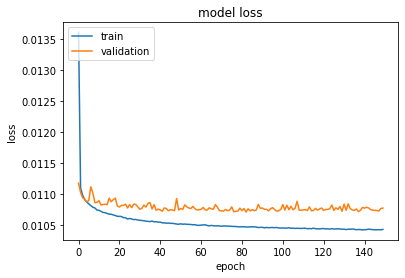

In [41]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


https://datascienceplus.com/keras-regression-based-neural-networks/

# 4. Проверка дополнительных гипотез

In [54]:
# генерация дополнительных признаков
# Xy.loc[:, ['title']] = Xy.title.apply(str)

# Xy.loc[:, ['doc']] = Xy.title.progress_apply(nlp)

# длина заголовка в символах
# Xy.loc[:, ['len']] = Xy.title.apply(len)

# количество токенов
# Xy.loc[:, ['tokens_num']] = Xy.tokens.apply(lambda x: len(x))

In [10]:
X_train = torch.from_numpy(X_train).float().to(device)

In [11]:
y_train = torch.from_numpy(y_train.values).float().to(device)